# Recurrent Neural Networks (LSTM): Time Series Forecasting

### The Problem
Predicting the future. 
We have a sequence of data: $x_1, x_2, x_3 ... x_t$.
We want to predict $x_{t+1}$.

### Why not simple ANN?
An ANN sees the input as a static blob. It doesn't understand that "Price yesterday" affects "Price today".
**RNNs** have an internal memory loop.
**LSTMs** (Long Short-Term Memory) are a smarter RNN that can remember things from long ago (avoiding the "Vanishing Gradient" problem).

> **Note:** Real stock prices are random walks (Efficient Market Hypothesis). They are impossible to predict perfectly. We will use a **Sine Wave with Noise** to mimic a stock-like pattern that is actually predictable, to prove the AI learns.

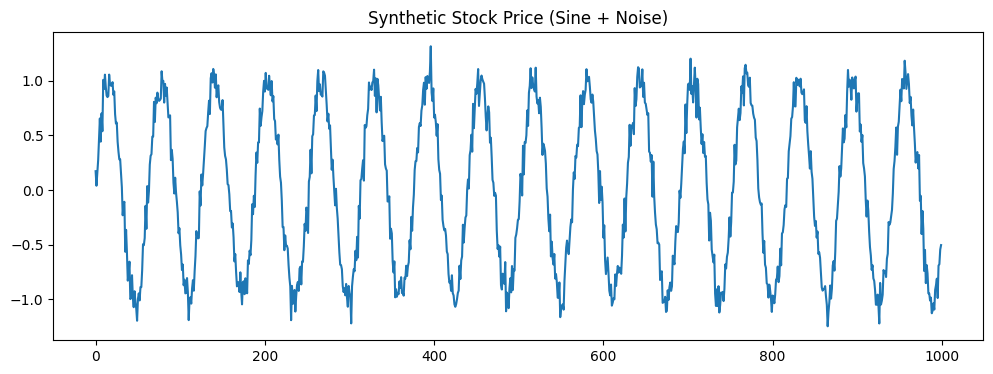

In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate Synthetic "Stock" Data
# A Sine wave (Pattern) + Random Noise (Chaos)
t = np.linspace(0, 100, 1000)
price = np.sin(t) + np.random.normal(0, 0.1, 1000)

plt.figure(figsize=(12,4))
plt.plot(price)
plt.title("Synthetic Stock Price (Sine + Noise)")
plt.show()

## 2. Preprocessing: Sliding Window
RNNs need a **Sequence**.
We can't just throw in one number.
We need to feed it: `[Day 1, Day 2, ... Day 30]` -> Predict `Day 31`.

This is called a **Sliding Window** or **Lookback**. 
- Input Shape: `(Batch_Size, Sequence_Length, Features)`
- Our Features = 1 (Just the Price).

In [13]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 30 # Look back 30 steps

X, y = create_sequences(price, SEQ_LENGTH)

# Split Train/Test (First 800 for train, rest for test)
train_size = 800
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Convert to PyTorch Tensors
# Reshape to (Batch, Seq_Length, Features)
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2) 
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

print(f"Input Shape: {X_train.shape}") # Should be (800, 30, 1)

Input Shape: torch.Size([800, 30, 1])


## 3. The LSTM Model
PyTorch makes this easy: `nn.LSTM`.

In [14]:
class StockPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(StockPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM Layer
        # batch_first=True means input is (Batch, Seq, Feature)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully Connected Layer (to map hidden state -> output price)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # Initialize hidden state (h0) and cell state (c0)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Propagate input through LSTM
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        
        # We only want the output of the LAST time step
        out = out[:, -1, :]
        
        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

model = StockPredictor()
print(model)

StockPredictor(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


## 4. Training

Epoch 10, Loss: 0.0457
Epoch 20, Loss: 0.0209
Epoch 30, Loss: 0.0193
Epoch 40, Loss: 0.0181
Epoch 50, Loss: 0.0169


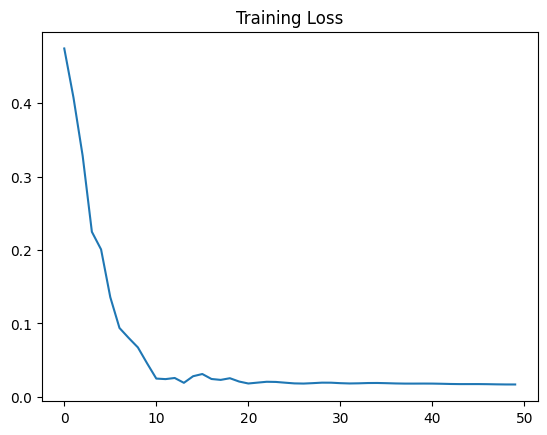

In [15]:
criterion = nn.MSELoss() # Regression problem -> Mean Squared Error
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 50
train_losses = []

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

plt.plot(train_losses)
plt.title("Training Loss")
plt.show()

## 5. Visualizing the Future
Let's see if it can follow the pattern.

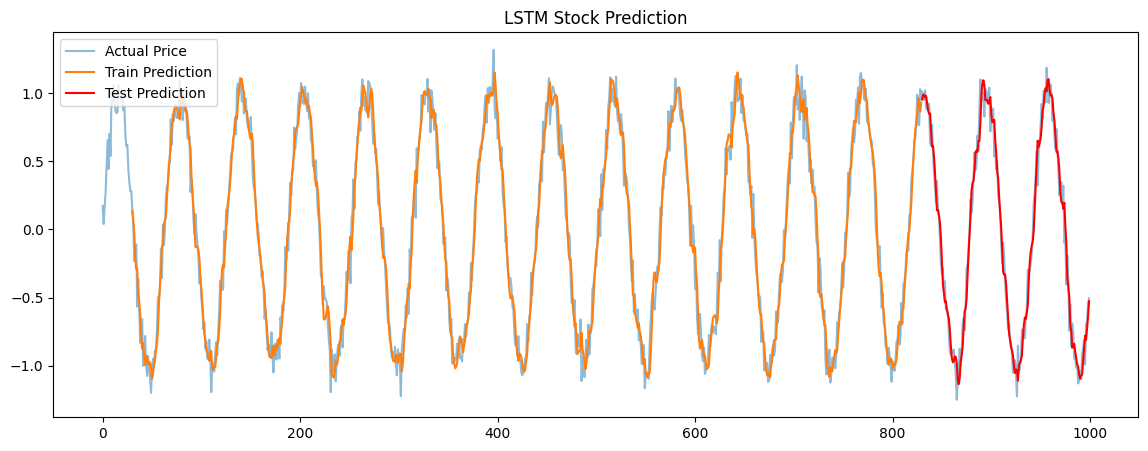

In [16]:
model.eval()
with torch.no_grad():
    train_pred = model(X_train).numpy()
    test_pred = model(X_test).numpy()

# Shift train predictions for plotting
train_plot = np.empty_like(price)
train_plot[:] = np.nan
train_plot[SEQ_LENGTH:len(train_pred)+SEQ_LENGTH] = train_pred.flatten()

# Shift test predictions for plotting
test_start = SEQ_LENGTH + len(train_pred)
test_end = test_start + len(test_pred)
test_plot = np.empty_like(price)
test_plot[:] = np.nan
test_plot[test_start:test_end] = test_pred.flatten()

# Plot
plt.figure(figsize=(14,5))
plt.plot(price, label='Actual Price', alpha=0.5)
plt.plot(train_plot, label='Train Prediction')
plt.plot(test_plot, label='Test Prediction', color='red')
plt.title("LSTM Stock Prediction")
plt.legend()
plt.show()

# Part 2: Real World Data (AAPL)

Synthetic data is cute, but boring. Let's try to predict **Apple (AAPL)** stock.
We will use `yfinance` to download live market data.

In [17]:
# Install yfinance if you haven't already
!pip install yfinance pandas_datareader

/tmp/ipython-input-2300286274.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2015-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed


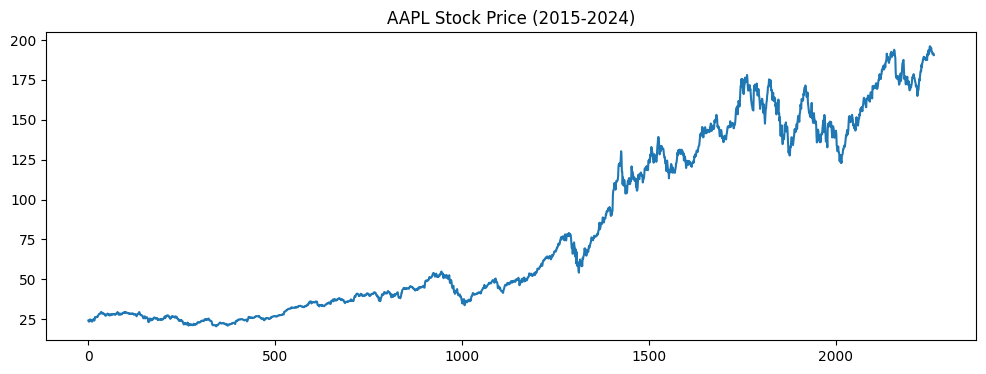

In [18]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

# 1. Download Data
ticker = 'AAPL'
data = yf.download(ticker, start='2015-01-01', end='2024-01-01')

# We only care about 'Close' price
real_price = data['Close'].values.reshape(-1, 1)

plt.figure(figsize=(12,4))
plt.plot(real_price)
plt.title(f"{ticker} Stock Price (2015-2024)")
plt.show()

## 2. Preprocessing (Normalization is Key)
Stock prices can be \$100 or \$1000. LSTMs work best with numbers between 0 and 1.
We **MUST** scale this data, or the gradients will explode.

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(real_price)

# Create Sequences using our previous function
SEQ_LENGTH = 60 # Look back 60 days (approx 3 months)
X_real, y_real = create_sequences(scaled_data, SEQ_LENGTH)

# Train/Test Split (Time-based)
train_size = int(len(X_real) * 0.8)
X_train_real, y_train_real = X_real[:train_size], y_real[:train_size]
X_test_real, y_test_real = X_real[train_size:], y_real[train_size:]

# Convert to Tensors
# Note: Data is already (SEQ, 1) from MinMaxScaler, create_sequences adds the window dim
# Shape needed: (Batch, Seq, Feature)
X_train_real = torch.tensor(X_train_real, dtype=torch.float32)
y_train_real = torch.tensor(y_train_real, dtype=torch.float32)
X_test_real = torch.tensor(X_test_real, dtype=torch.float32)
y_test_real = torch.tensor(y_test_real, dtype=torch.float32)

print(f"Real Data Input Shape: {X_train_real.shape}")

Real Data Input Shape: torch.Size([1763, 60, 1])


## 3. Retrain the LSTM
We re-initialize the model to start fresh.

Epoch 10, Loss: 0.0563
Epoch 20, Loss: 0.0437
Epoch 30, Loss: 0.0142
Epoch 40, Loss: 0.0067
Epoch 50, Loss: 0.0021


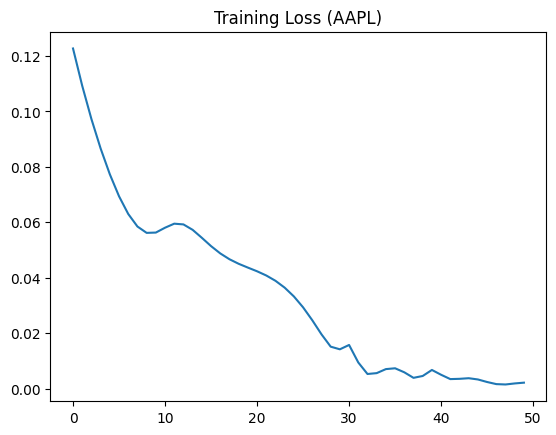

In [20]:
model_real = StockPredictor(input_size=1, hidden_size=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_real.parameters(), lr=0.001)

epochs = 50
losses_real = []

model_real.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model_real(X_train_real)
    loss = criterion(output, y_train_real)
    loss.backward()
    optimizer.step()
    
    losses_real.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

plt.plot(losses_real)
plt.title("Training Loss (AAPL)")
plt.show()

## 4. Evaluation
Note: The model predicts the **Scaled Price (0-1)**. We need to `inverse_transform` to get dollars.

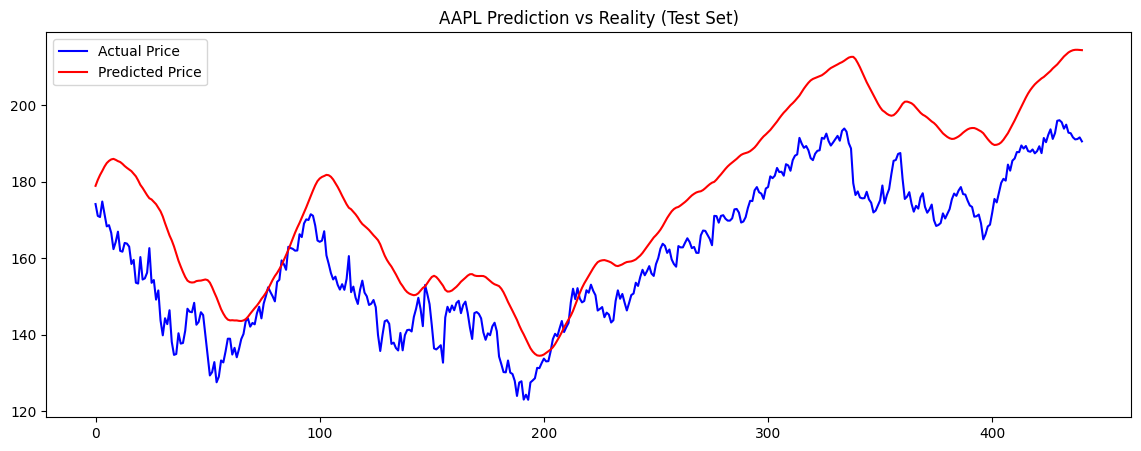

In [21]:
model_real.eval()
with torch.no_grad():
    test_pred_real = model_real(X_test_real).numpy()

# Inverse Scale
test_pred_real_prices = scaler.inverse_transform(test_pred_real)
y_test_real_prices = scaler.inverse_transform(y_test_real.numpy())

plt.figure(figsize=(14,5))
plt.plot(y_test_real_prices, label='Actual Price', color='blue')
plt.plot(test_pred_real_prices, label='Predicted Price', color='red')
plt.title("AAPL Prediction vs Reality (Test Set)")
plt.legend()
plt.show()